# <center>Document Cleanup</center>

# Victor Francisco
email: victorfco27@gmail.com

# Brief approach overview

I decided to use a few of the most common techniques in image processing area. I also went further and tried to create a CNN to encode and decode the noisy image according to the filtered images. The ideia of using CNN is to increase text resolution since the combination of many filters can degradate image text quality.

Remember of creating a folder to output the cleaned images.

## Importing all necessary libraries

In [1]:
import os
import math
import glob
import scipy.misc
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread, imshow
from skimage.filters import gaussian, threshold_otsu, median
from skimage.feature import canny
from skimage.morphology import disk, dilation, erosion
from skimage.transform import probabilistic_hough_line, rotate
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate
from keras.models import Model
%matplotlib inline

Using TensorFlow backend.
/home/victorfco/.virtualenvs/glucogear/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/victorfco/.virtualenvs/glucogear/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/victorfco/.virtualenvs/glucogear/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vi

## Image processing functions

### Create a pad surrounding the image

Parameters: array corresponding to the image, integer representing size in pixels for the final height and width, and a boolean to choose the padding color (white or black).

Returns: array corresponding to the padded image.

This function creates a border in the image in order to make it squared (same height and width).

In [2]:
def padding_img(img, final_size, padding_black = False):
    h_pad = final_size - img.shape[0]
    w_pad = final_size - img.shape[1]
    
    
    # Calculating pad size to apply on image based on desired size and image real size
    top = h_pad/2
    if top.is_integer():
        bottom = top
    else:
        top = math.ceil(top)
        bottom = math.floor(top)-1
        
    left = w_pad/2
    if left.is_integer():
        right = left
    else:
        left = math.ceil(left)
        right = math.floor(left)-1

    color = [255, 255, 255]    
    if padding_black:
        color = [0, 0, 0]

    new_img = cv.copyMakeBorder(img, int(top), int(bottom), int(left), int(right), cv.BORDER_CONSTANT, value = color)
    
    return new_img

### Function to fix text rotation

Parameters: array representing the image.

Returns: array of fixed image.

This function makes use of threshold to remove some noises on the image, gaussian filter blurring the text so canny algorithm identify edges. Then, Hough transform to identify lines within image and then histogram to identify most common angles so we can calculate the necessary rotation angle.

In [3]:
def fix_rotation(img):

    #threshold to get rid of extraneous noise
    thresh = threshold_otsu(img)
    normalize = img > thresh

    # gaussian blur
    blur = gaussian(normalize, 3)

    # canny edges in scikit-image
    edges = canny(blur)

    # hough lines
    hough_lines = probabilistic_hough_line(edges)

    # hough lines returns a list of points, in the form ((x1, y1), (x2, y2))
    # representing line segments. the first step is to calculate the slopes of
    # these lines from their paired point values
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else 0 for (x1,y1), (x2, y2) in hough_lines]

    # it just so happens that this slope is also y where y = tan(theta), the angle
    # in a circle by which the line is offset
    rad_angles = [np.arctan(x) for x in slopes]

    # and we change to degrees for the rotation
    deg_angles = [np.degrees(x) for x in rad_angles]

    # which of these degree values is most common?
    histo = np.histogram(deg_angles, bins=180)
    
    # correcting for 'sideways' alignments
    rotation_angle = histo[1][np.argmax(histo[0])]

    if rotation_angle > 45:
        rotation_angle = -(90-rotation_angle)
    elif rotation_angle < -45:
        rotation_angle = 90 - abs(rotation_angle)
        
    center = (img.shape[0] // 2, img.shape[1] // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, round(rotation_angle, 2), 1.0)
    rotated_img = cv.warpAffine(img, rotation_matrix, (img.shape[0], img.shape[1]),
                                flags=cv.INTER_CUBIC, borderMode=cv.BORDER_CONSTANT,
                               borderValue=255)

    return rotated_img

### Removes the background for cleaner image

Parameters: image as an array

Returns: image array with subtracted background

Applying a median filter we can make the text blend with the background, then we subtract the background from the actual image.

In [4]:
def background_removal(img):
    
    # uses a median filter to remove text from image, resulting in only background (noise)
    filtered_img = median(img, disk(9))
    
    # subtracting background from original image
    subtracted_img = cv.subtract(filtered_img, img)

    # cv.subtract results in a negative image, so we need to return it to white background and black text
    subtracted_img = ~subtracted_img
    
    return subtracted_img

### Adjusts the image contrast

Parameters: image as array and an integer representing the level of contrast.

Returns: array reprensenting the image with contrast correction.

In [5]:
def contrast_adjustment(img, level):
    img = Image.fromarray(img)
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

## Image manipulation

Open the noisy image from folder and apply the image processing functions to it. Then creates a list of noisy and cleaned images to use in the Convolution Neural Network. In this case, we also apply padding and fix rotation to noisy images to use as input to the CNN.

Note: It is recommended to set img_height and img_width to values greater or equal to the max height or width among all input images.


DO NOT FORGET OF CREATING A FOLDER FOR CLEAN IMAGES.

In [6]:
noisy_path = '/media/victorfco/Storage/Projects/Data/candidate-data/01-DocumentCleanup/noisy_data'
clean_path = '/media/victorfco/Storage/Projects/Data/candidate-data/01-DocumentCleanup/clean_data'

noisy_imgs = glob.glob(noisy_path + "/*" )
clean_list = []
noisy_list = []

# Define the size for your image after padding. HEIGHT and WIDTH MUST BE THE SAME
# Chose values greater or equal to the max height or width among all input images
img_height = 640
img_width = 640


for image in noisy_imgs:
    img_file = image.split('/')[-1]
    noisy = imread(image, as_gray = True)
    clean = padding_img(noisy, img_height, padding_black = False)
    clean = fix_rotation(clean)
    clean = background_removal(clean)
    
    noisy = padding_img(noisy, img_height, padding_black = False)
    noisy = fix_rotation(noisy)
    
    # Append clean and noisy images with propoer shape with 1 color channel for CNN
    clean_list.append(np.stack((clean,)*1, axis = -1))
    noisy_list.append(np.stack((noisy,)*1, axis = -1))

In [7]:
clean_list = np.asarray(clean_list)
noisy_list = np.asarray(noisy_list)

In [8]:
clean_list = clean_list/255
noisy_list = noisy_list/255

In [9]:
clean_list.shape

(144, 640, 640, 1)

## Using CNN to improve text in the final image

The usage of CNN in this case is to try to improve text resolution. The ideia is to use a simple CNN to encode and decode an image. This way we expect to be able to easily read the text.

In [10]:
def create_cnn(input_shape):   
    input_layer = Input(shape=input_shape)
    
    cnn = Conv2D(64, (3,3), activation = 'relu', strides=1, padding='same')(input_layer) 
    cnn = MaxPooling2D((2, 2), padding='same')(cnn)
    
    cnn = Conv2D(64, (3, 3), activation = 'relu', strides=1, padding='same')(cnn)
    cnn = UpSampling2D((2,2))(cnn)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(cnn)
        
    cnn = Model(inputs=input_layer, outputs=output_layer)
    
    return cnn

Due to computational limitations, the batch size is set as 4. Feel free to adjust this parameter according to your PC computational capacity.

In [11]:
input_shape = (img_height, img_width, 1)

X_train = noisy_list
y_train = clean_list

classifier = create_cnn(input_shape)   
    
classifier.compile(loss = 'mse', optimizer = 'adam')

cnn = classifier.fit(X_train, y_train, epochs = 80, batch_size = 4, shuffle = True, verbose = 2)  

Epoch 1/80
 - 22s - loss: 0.0420
Epoch 2/80
 - 17s - loss: 0.0152
Epoch 3/80
 - 16s - loss: 0.0094
Epoch 4/80
 - 17s - loss: 0.0079
Epoch 5/80
 - 16s - loss: 0.0071
Epoch 6/80
 - 16s - loss: 0.0067
Epoch 7/80
 - 16s - loss: 0.0064
Epoch 8/80
 - 16s - loss: 0.0062
Epoch 9/80
 - 16s - loss: 0.0060
Epoch 10/80
 - 17s - loss: 0.0060
Epoch 11/80
 - 16s - loss: 0.0058
Epoch 12/80
 - 16s - loss: 0.0057
Epoch 13/80
 - 17s - loss: 0.0057
Epoch 14/80
 - 17s - loss: 0.0057
Epoch 15/80
 - 17s - loss: 0.0056
Epoch 16/80
 - 16s - loss: 0.0058
Epoch 17/80
 - 17s - loss: 0.0057
Epoch 18/80
 - 17s - loss: 0.0055
Epoch 19/80
 - 16s - loss: 0.0056
Epoch 20/80
 - 16s - loss: 0.0057
Epoch 21/80
 - 17s - loss: 0.0055
Epoch 22/80
 - 17s - loss: 0.0056
Epoch 23/80
 - 16s - loss: 0.0056
Epoch 24/80
 - 16s - loss: 0.0055
Epoch 25/80
 - 16s - loss: 0.0056
Epoch 26/80
 - 17s - loss: 0.0055
Epoch 27/80
 - 16s - loss: 0.0055
Epoch 28/80
 - 16s - loss: 0.0054
Epoch 29/80
 - 16s - loss: 0.0055
Epoch 30/80
 - 16s - lo

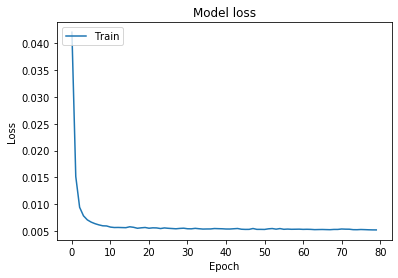

In [12]:
plt.plot(cnn.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Saving CNN predicted decoded images

In [14]:
# for i in range(0, 2):
for i in range(0, X_train.shape[0]):
    img_file = noisy_imgs[i].split('/')[-1]
    
    # Commented lines are for debugging purposes
#     fig = plt.figure()
#     fig.set_size_inches(25, 10)

#     plt.subplot(1, 3, 1)
#     image = X_train[i] * 255.0
#     image = image.reshape(img_width, img_height)
#     plt.imshow(image, cmap='gray')

#     plt.subplot(1, 3, 2)
#     image = y_train[i] * 255.0
#     image = image.reshape(img_width, img_height)
#     plt.imshow(image, cmap='gray')


#     plt.subplot(1, 3, 3)
    predict = classifier.predict(X_train[i].reshape(1, img_width, img_height, 1))
    predict = predict * 255
    predict = predict.reshape(img_width, img_height)
#     plt.imshow(predict, cmap='gray')

    # Applying threshold to predicted image and save it as binary (0's and 255's)
    rotaded = fix_rotation(predict)
    thres = threshold_otsu(rotaded)
    normalize = rotaded > thres
    normalize = normalize.astype(int)
    normalize = normalize * 255
    
    cv.imwrite('{}/{}'.format(clean_path, img_file), normalize)
